In [1]:
import os
os.chdir("../")

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
from PIL import Image
matplotlib.get_cachedir()
plt.rc('font', family="Times New Roman")

# https://github.com/facebookresearch/ImageBind
from imagebind import data
from imagebind.data import waveform2melspec, get_clip_timepoints
import torch
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

from utils import vggsound_template, vggsound_classes

from sklearn import metrics

import torch
from torchvision import transforms

import torchaudio
from pytorchvideo.data.clip_sampling import ConstantClipsPerVideoSampler

/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [2]:
clip_sampler = ConstantClipsPerVideoSampler(
    clip_duration=2, clips_per_video=3
)

In [3]:
def imshow(img):
    """
    Visualizing images inside jupyter notebook
    """
    plt.axis('off')
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()
    
def denormalize(tensor, mean, std):
    """
    对归一化后的张量进行反归一化处理。
    
    参数:
    tensor: 归一化后的张量
    mean: 均值
    std: 标准差
    
    返回:
    反归一化后的张量
    """
    return tensor * std + mean

def visualize_audio_spectrogram(tensor, mean= -4.268, std= 9.138, channel = 0):
    """
    对音频频谱张量进行反归一化并可视化。
    
    参数:
    tensor: 形状为 (3, 1, 128, 204) 的张量
    mean: 归一化时使用的均值
    std: 归一化时使用的标准差
    """
    # 假设我们使用第一个通道进行可视化
    tensor = tensor[channel, 0, :, :]

    # 对张量进行反归一化
    denormalized_tensor = denormalize(tensor, mean, std)

    # 绘制反归一化后的频谱图
    plt.figure(figsize=(10, 4))
    plt.imshow(denormalized_tensor, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Denormalized Audio Spectrogram')
    plt.xlabel('Time Frames')
    plt.ylabel('Mel Frequency Bins')
    plt.show()
    
def visualize_rgb_spectrogram(spectrogram):
    """
    可视化 RGB 梅尔频谱图。

    参数:
    spectrogram: 形状为 (3, 128, 204) 的梅尔频谱图（3 个通道）

    返回:
    None
    """
    # 确保输入的频谱图有 3 个通道
    assert spectrogram.shape[0] == 3, "Spectrogram must have 3 channels."

    # 将频谱图从 (3, H, W) 转换为 (H, W, 3)
    spectrogram_rgb = np.transpose(spectrogram, (1, 2, 0))

    # 显示 RGB 梅尔频谱图
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram_rgb, aspect='auto', origin='lower')
    plt.title('RGB Spectrogram')
    plt.xlabel('Time Frames')
    plt.ylabel('Mel Frequency Bins')
    plt.show()

def convert_mfcc(spectrogram, mean= -4.268, std= 9.138, channel = 0):
    # 确保输入的频谱图有 3 个通道
    assert spectrogram.shape[0] == 3, "Spectrogram must have 3 channels."
    
    spectrogram = spectrogram[channel, 0, :, :]
    
    denormalized_tensor = denormalize(spectrogram, mean, std)
    
    return denormalized_tensor

### 🛠️ Models and preprocessing function setup
Since multi-modal models, such as CLIP, have dual-stream input, we need its image encoder. The input is an image `[B, C, W, H]` in torch format, and the output is a d-dimensional vector `[B, d]`. So please convert the model, let's take `ImageBind` as an example:

In [4]:
class ImageBindModel_Super(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        
    def forward(self, audio_inputs):
        """
        Input:
            audio_inputs: torch.size([B,C,W,H])
        Output:
            embeddings: a d-dimensional vector torch.size([B,d])
        """
        inputs = {
            "audio": audio_inputs,
        }
        
        with torch.no_grad():
            embeddings = self.base_model(inputs)
        
        return embeddings["audio"]

In [5]:
def read_audio(
    audio_path,
    device,
    num_mel_bins=128,
    target_length=204,
    sample_rate=16000,
    mean= -4.268, 
    std= 9.138
):
    waveform, sr = torchaudio.load(audio_path)
    if sample_rate != sr:
        waveform = torchaudio.functional.resample(
            waveform, orig_freq=sr, new_freq=sample_rate
        )
    all_clips_timepoints = get_clip_timepoints(
        clip_sampler, waveform.size(1) / sample_rate
    )
    all_clips = []
    for clip_timepoints in all_clips_timepoints:
        waveform_clip = waveform[
            :,
            int(clip_timepoints[0] * sample_rate) : int(
                clip_timepoints[1] * sample_rate
            ),
        ]
        waveform_melspec = waveform2melspec(
            waveform_clip, sample_rate, num_mel_bins, target_length
        )
        all_clips.append(waveform_melspec)

    normalize = transforms.Normalize(mean=mean, std=std)
    all_clips = [normalize(ac).to(device) for ac in all_clips]

    all_clips = torch.stack(all_clips, dim=0)
    return all_clips.cpu().numpy()

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

audio_model = ImageBindModel_Super(model)
print("load imagebind model")

load imagebind model


In [7]:
audio_path = ["/home/cry/J-16/Datasets/vggsound/audio/test/bZadyuv2utE_000080.flac"]
audio_input = read_audio(audio_path[0], device)

label = 35

In [8]:
audio_feature = audio_model(torch.from_numpy(audio_input).unsqueeze(0).to(device))
print("The output size of the audio feature is {}.".format(audio_feature.shape))

The output size of the audio feature is torch.Size([1, 1024]).


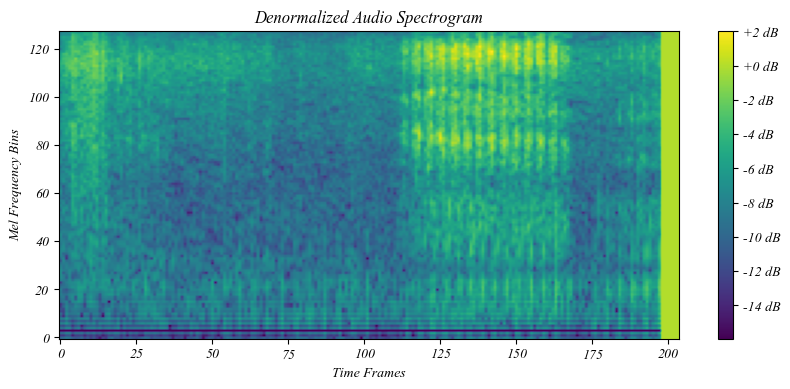

In [9]:
visualize_audio_spectrogram(audio_input, channel = 0)

### ✏️ Audio Division

For example, you can use patch to segment the image, as shown below:

In [10]:
def Partition_by_patch(image, partition_size=(8,8)):
    """_summary_

    Args:
        image (torch): [c,d,w,h]
        partition_size (int, optional): _description_. Defaults to 10.

    Returns:
        _type_: _description_
    """
    pixel_length = image.shape[2] / partition_size[0]
    pixel_width = image.shape[3] / partition_size[1]
    
    components_image_list = []
    for i in range(partition_size[0]):
        for j in range(partition_size[1]):
            image_tmp = np.zeros_like(image)
            image_tmp[:,:,int(i*pixel_length) : int((i+1)*pixel_length), int(j*pixel_width) : int((j+1)*pixel_width)] = image[:,:, int(i*pixel_length) : int((i+1)*pixel_length), int(j*pixel_width) : int((j+1)*pixel_width)]
            
            components_image_list.append(image_tmp)
    return components_image_list

In [11]:
element_sets_V = Partition_by_patch(audio_input)

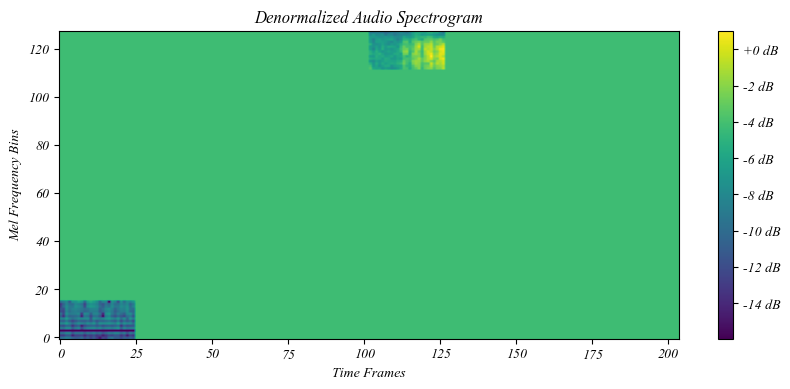

In [12]:
visualize_audio_spectrogram(element_sets_V[0]+element_sets_V[-4], channel = 0)

### 🔥 Attribution

In [13]:
from models.submodular_audio_efficient_plus import AudioSubModularExplanationEfficientPlus

In [14]:
semantic_feature = torch.load("ckpt/semantic_features/vggsound_imagebind_cls.pt", map_location=device) * 0.05

In [15]:
def transform_audio_data(audio_numpy):
    audio = torch.from_numpy(audio_numpy)
    return audio

In [16]:
explainer = AudioSubModularExplanationEfficientPlus(
        audio_model, semantic_feature, transform_audio_data, device=device, 
        lambda1=0.01, 
        lambda2=0., 
        lambda3=20., 
        lambda4=5.)

In [17]:
explainer.k = len(element_sets_V)
submodular_image, submodular_image_set, saved_json_file = explainer(element_sets_V, id=label)

 97%|█████████▋| 35/36 [00:33<00:00,  1.05it/s]


In [18]:
submodular_image_set[:21].sum(0).shape

(3, 1, 128, 204)

In [19]:
saved_json_file["consistency_score"][20]

0.8729357719421387

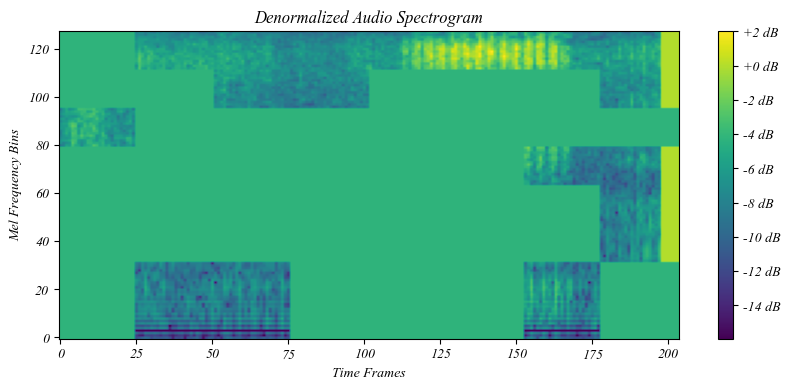

In [20]:
visualize_audio_spectrogram(submodular_image_set[:21].sum(0), channel = 0)

### 😮 Visualization

In [21]:
def visualization(image, submodular_image_set, saved_json_file, index=None):
    insertion_ours_images = []
    deletion_ours_images = []

    insertion_image = submodular_image_set[0] - submodular_image_set[0]
    insertion_ours_images.append(insertion_image)
    deletion_ours_images.append(image - insertion_image)
    for smdl_sub_mask in submodular_image_set[:]:
        insertion_image = insertion_image.copy() + smdl_sub_mask
        insertion_ours_images.append(insertion_image)
        deletion_ours_images.append(image - insertion_image)

    insertion_ours_images_input_results = np.array([saved_json_file["baseline_score"]] + saved_json_file["consistency_score"])

    if index == None:
        ours_best_index = np.argmax(insertion_ours_images_input_results)
    else:
        ours_best_index = index
    x = [j/len(saved_json_file["consistency_score"]) for j in range(len(saved_json_file["consistency_score"])+1)]
    i = len(x)

    fig = plt.figure(figsize=(24,8))
    # fig, [ax2, ax3] = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 1.5]}, figsize=(24,8))
    gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1.5])
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_title('Spectrogram Attribution', fontsize=54)
    ax1.set_facecolor('white')
    
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    # ax2.set_title('Ours', fontsize=54)
    ax2.set_facecolor('white')
    
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.spines["left"].set_visible(False)
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["bottom"].set_visible(False)
    ax3.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    # ax3.set_title('Ours', fontsize=54)
    ax3.set_facecolor('white')

    ax4 = fig.add_subplot(gs[:, 1])
    ax4.set_xlim((0, 1))
    ax4.set_ylim((0, 1))
    ax4.set_title('Insertion', fontsize=54)
    ax4.set_ylabel('Recognition Score', fontsize=44)
    ax4.set_xlabel('Percentage of image revealed', fontsize=44)
    ax4.tick_params(axis='both', which='major', labelsize=36)

    x_ = x[:i]
    print(x_)
    ours_y = insertion_ours_images_input_results[:i]
    ax4.plot(x_, ours_y, color='dodgerblue', linewidth=3.5)  # draw curve
    ax4.set_facecolor('white')
    ax4.spines['bottom'].set_color('black')
    ax4.spines['bottom'].set_linewidth(2.0)
    ax4.spines['top'].set_color('none')
    ax4.spines['left'].set_color('black')
    ax4.spines['left'].set_linewidth(2.0)
    ax4.spines['right'].set_color('none')

    # plt.legend(["Ours"], fontsize=40, loc="upper left")
    ax4.scatter(x_[-1], ours_y[-1], color='dodgerblue', s=54)  # Plot latest point
    # 在曲线下方填充淡蓝色
    ax4.fill_between(x_, ours_y, color='dodgerblue', alpha=0.1)

    ax4.axvline(x=x_[ours_best_index], color='red', linewidth=3.5)  # 绘制红色垂直线

    # Ours
    ax1.imshow(convert_mfcc(insertion_ours_images[ours_best_index], channel = 0), aspect='auto', origin='lower', cmap='viridis')
    
    ax2.imshow(convert_mfcc(insertion_ours_images[ours_best_index], channel = 1), aspect='auto', origin='lower', cmap='viridis')
    
    ax3.imshow(convert_mfcc(insertion_ours_images[ours_best_index], channel = 1), aspect='auto', origin='lower', cmap='viridis')

    auc = metrics.auc(x, insertion_ours_images_input_results)

    print("Highest confidence: {}\nfinal confidence: {}\nInsertion AUC: {}".format(insertion_ours_images_input_results.max(), insertion_ours_images_input_results[-1], auc))
    
def gen_cam(image_path, mask):
    """
    Generate heatmap
        :param image: [H,W,C]
        :param mask: [H,W],range 0-1
        :return: tuple(cam,heatmap)
    """
    # Read image
    image = cv2.resize(cv2.imread(image_path), (224,224))
    # mask->heatmap
    heatmap = cv2.applyColorMap(np.uint8(mask), cv2.COLORMAP_COOL)
    heatmap = np.float32(heatmap)

    # merge heatmap to original image
    cam = 0.5*heatmap + 0.5*np.float32(image)
    return cam, (heatmap).astype(np.uint8)

def norm_image(image):
    """
    Normalization image
    :param image: [H,W,C]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)

[0.0, 0.015625, 0.03125, 0.046875, 0.0625, 0.078125, 0.09375, 0.109375, 0.125, 0.140625, 0.15625, 0.171875, 0.1875, 0.203125, 0.21875, 0.234375, 0.25, 0.265625, 0.28125, 0.296875, 0.3125, 0.328125, 0.34375, 0.359375, 0.375, 0.390625, 0.40625, 0.421875, 0.4375, 0.453125, 0.46875, 0.484375, 0.5, 0.515625, 0.53125, 0.546875, 0.5625, 0.578125, 0.59375, 0.609375, 0.625, 0.640625, 0.65625, 0.671875, 0.6875, 0.703125, 0.71875, 0.734375, 0.75, 0.765625, 0.78125, 0.796875, 0.8125, 0.828125, 0.84375, 0.859375, 0.875, 0.890625, 0.90625, 0.921875, 0.9375, 0.953125, 0.96875, 0.984375, 1.0]
Highest confidence: 0.9924357533454895
final confidence: 0.9660196304321289
Insertion AUC: 0.6959036202365468


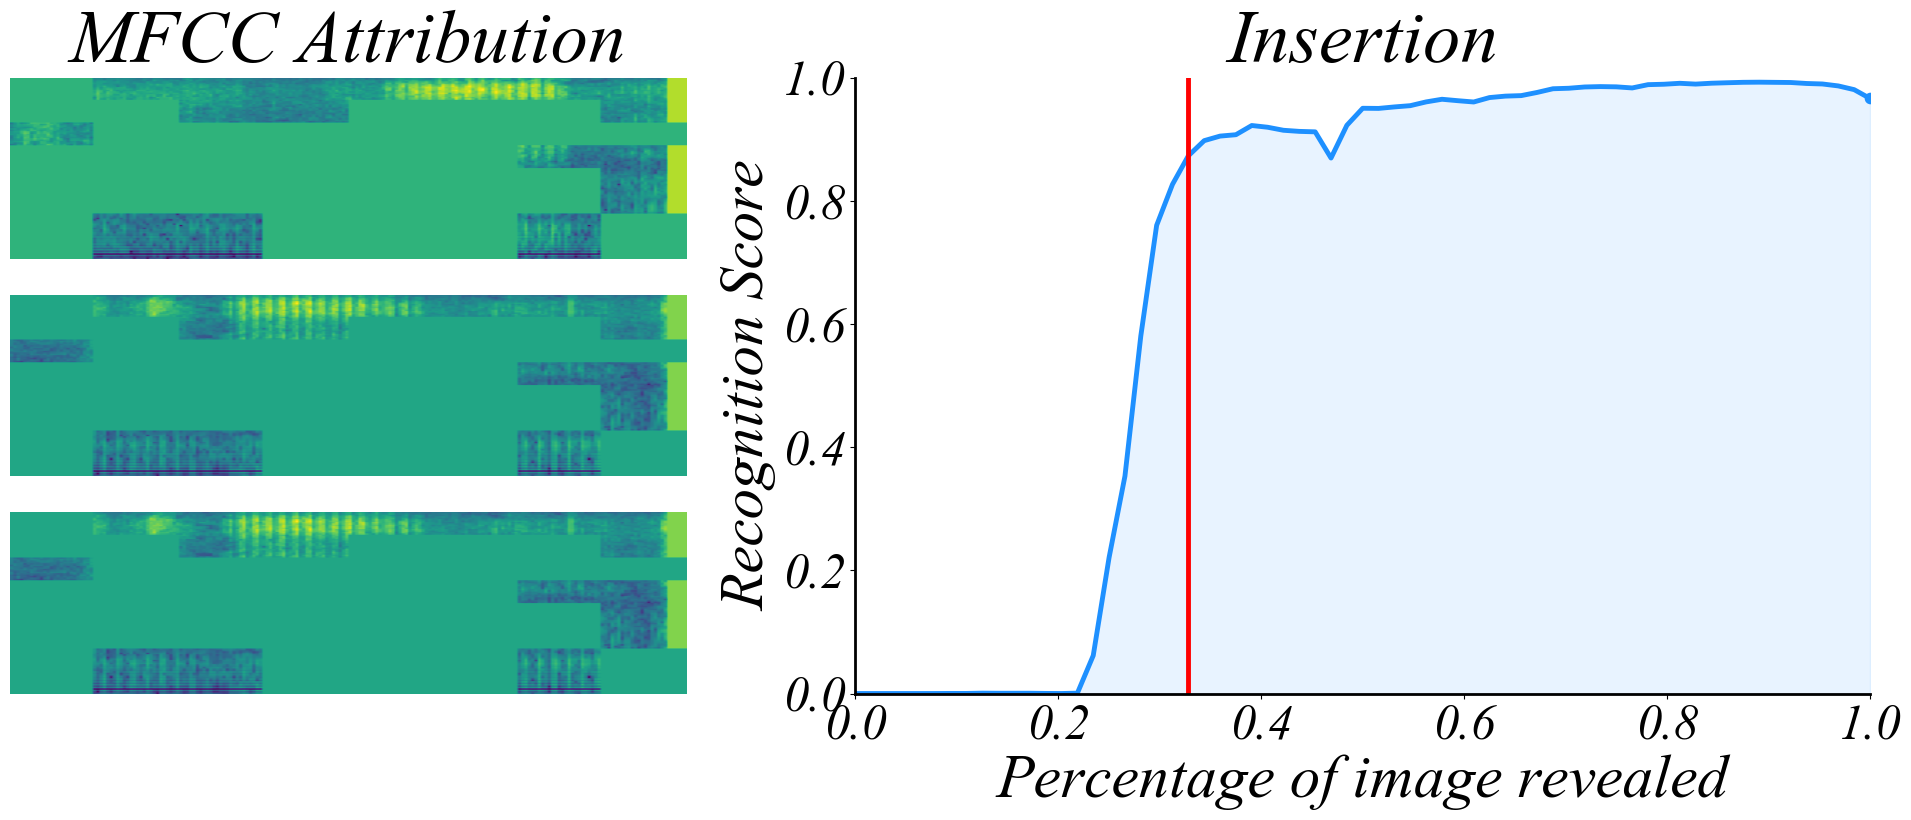

In [22]:
visualization(audio_input, submodular_image_set, saved_json_file,21)